<a href="https://colab.research.google.com/github/vadhri/cuda-programming-notebook/blob/main/pde/2d_heat_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The heat diffusion equation is a 2d pde that could be used with cuda to speed up computation time.

### CPU - diffusion 100x100 grid at 0.1s

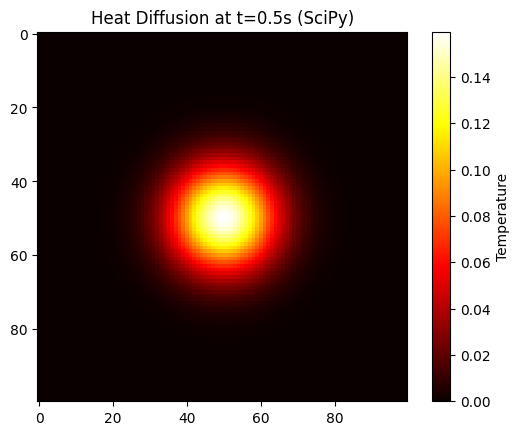

In [49]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

def heat_equation(t, u, N, alpha, dx, dy):
    """ Computes du/dt for the 2D heat equation using finite difference """
    u = u.reshape((N, N))
    dudt = np.zeros_like(u)

    # Apply finite difference scheme
    for i in range(1, N-1):
        for j in range(1, N-1):
            dudt[i, j] = alpha * (
                (u[i+1, j] - 2*u[i, j] + u[i-1, j]) / dx**2 +
                (u[i, j+1] - 2*u[i, j] + u[i, j-1]) / dy**2
            )

    return dudt.flatten()

# Grid settings
N = 100    # Grid size (50x50)
dx = 0.01  # Spatial step in x-direction
dy = 0.01  # Spatial step in y-direction
alpha = 0.01  # Thermal diffusivity
dt = 0.001  # Time step

# Initial condition (heat at center)
u0 = np.zeros((N, N))
u0[N//2, N//2] = 100  # Heat source at center
u0 = u0.flatten()

# Solve the PDE using SciPy's ODE solver
sol = scipy.integrate.solve_ivp(
    heat_equation, t_span=[0, 0.5], y0=u0, args=(N, alpha, dx, dy), method='RK45'
)

# Extract final temperature distribution
u_final = sol.y[:, -1].reshape((N, N))

# Plot result
plt.imshow(u_final, cmap='hot', interpolation='nearest')
plt.colorbar(label="Temperature")
plt.title("Heat Diffusion at t=0.5s (SciPy)")
plt.show()


### CPU - diffusion 500x500 grid at 10s
Execution 40s

In [76]:
%%writefile heat_diffusion_2d.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#define N 500         // Grid size (N x N)
#define DX 0.01       // Spatial step in x-direction
#define DY 0.01       // Spatial step in y-direction
#define ALPHA 0.01    // Thermal diffusivity
#define DT 0.001      // Time step
#define TIME_STEPS 10000 // Number of time steps

void initialize(float u[N][N]) {
    // Set initial temperature to 0 everywhere
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            u[i][j] = 0.0;
        }
    }
    // Heat source at the center
    u[N / 2][N / 2] = 100.0;
}

void update_heat(float u[N][N], float u_new[N][N]) {
    for (int i = 1; i < N - 1; i++) {
        for (int j = 1; j < N - 1; j++) {
            float d2udx2 = (u[i+1][j] - 2 * u[i][j] + u[i-1][j]) / (DX * DX);
            float d2udy2 = (u[i][j+1] - 2 * u[i][j] + u[i][j-1]) / (DY * DY);
            u_new[i][j] = u[i][j] + ALPHA * DT * (d2udx2 + d2udy2);
        }
    }
}

int main() {
    float u[N][N], u_new[N][N];

    initialize(u);

    for (int t = 0; t < TIME_STEPS; t++) {
        update_heat(u, u_new);

        // Swap arrays
        for (int i = 0; i < N; i++)
            for (int j = 0; j < N; j++)
                u[i][j] = u_new[i][j];
    }

    FILE *file = fopen("heat_distribution.txt", "w");
    if (file == NULL) {
        printf("Error opening file!\n");
        return 0;
    }

    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            fprintf(file, "%f,", u[i][j]);
        }
        fprintf(file, "\n");
    }

    fclose(file);
    printf("Simulation completed. Results saved to heat_distribution.csv\n");

    return 0;
}


Overwriting heat_diffusion_2d.c


Simulation completed. Results saved to heat_distribution.csv

real	0m40.303s
user	0m39.854s
sys	0m0.024s


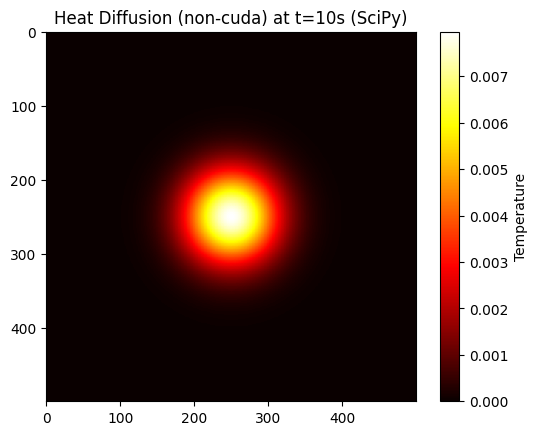

In [81]:
!gcc heat_diffusion_2d.c -o heat_diffusion_2d -lm
!time ./heat_diffusion_2d
output_2d_heatdiff = np.loadtxt("cuda_output.txt", delimiter=",")
# Plot result
plt.imshow(output_2d_heatdiff, cmap='hot', interpolation='nearest')
plt.colorbar(label="Temperature")
plt.title("Heat Diffusion (non-cuda) at t=10s (SciPy)")
plt.show()

### CPU - diffusion 500x500 grid at 10s
Execution 0.550s

In [78]:
%%writefile heat_diffusion_2d.cu

#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

#define GRID_N 500  // Grid size (N x N)
#define DX 0.01  // Space step in x-direction
#define DY 0.01  // Space step in y-direction
#define DT 0.001  // Time step
#define ALPHA 0.01  // Diffusivity constant
#define TIME_STEPS 10000  // Number of time iterations

// CUDA Kernel for Heat Diffusion
__global__ void heat_equation_kernel(float *u, float *u_new, int N, float alpha, float dx, float dy, float dt) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i > 0 && i < N-1 && j > 0 && j < N-1) {
        int idx = i * N + j;

        float d2udx2 = (u[(i+1)*N + j] - 2*u[idx] + u[(i-1)*N + j]) / (dx * dx);
        float d2udy2 = (u[i*N + (j+1)] - 2*u[idx] + u[i*N + (j-1)]) / (dy * dy);

        u_new[idx] = u[idx] + alpha * dt * (d2udx2 + d2udy2);
    }
}

// Host function to run the CUDA kernel
void heat_equation_cuda() {
    float *h_u, *h_u_new, *d_u, *d_u_new;
    int N = GRID_N;
    int size = N * N * sizeof(float);

    // Allocate memory on host
    h_u = (float*)malloc(size);
    h_u_new = (float*)malloc(size);

    // Initialize temperature grid (all zeros except a heat source in the center)
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            h_u[i * N + j] = 0.0f;
        }
    }
    h_u[(N/2) * N + (N/2)] = 100.0f;  // Heat source at the center

    // Allocate memory on device
    cudaMalloc((void**)&d_u, size);
    cudaMalloc((void**)&d_u_new, size);

    // Copy data to device
    cudaMemcpy(d_u, h_u, size, cudaMemcpyHostToDevice);

    // Define grid and block sizes
    dim3 threadsPerBlock(16, 16);
    dim3 blocksPerGrid((N + threadsPerBlock.x - 1) / threadsPerBlock.x,
                       (N + threadsPerBlock.y - 1) / threadsPerBlock.y);

    // Run time iterations
    for (int t = 0; t < TIME_STEPS; t++) {
        heat_equation_kernel<<<blocksPerGrid, threadsPerBlock>>>(d_u, d_u_new, GRID_N, ALPHA, DX, DY, DT);
        cudaMemcpy(d_u, d_u_new, size, cudaMemcpyDeviceToDevice);
    }

    // Copy result back to host
    cudaMemcpy(h_u, d_u, size, cudaMemcpyDeviceToHost);

    // Print final result (for verification)
    printf("Final Temperature Distribution:\n");
    FILE *file = fopen("cuda_output.txt", "w");
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            if (j > 0) {
              fprintf(file, ",");
            }
            fprintf(file, "%f", h_u[i * N + j]);
        }
        fprintf(file,"\n");
    }

    fclose(file);

    // Free memory
    free(h_u);
    free(h_u_new);
    cudaFree(d_u);
    cudaFree(d_u_new);
}

int main() {
    heat_equation_cuda();
    return 0;
}


Overwriting heat_diffusion_2d.cu


Final Temperature Distribution:

real	0m0.550s
user	0m0.292s
sys	0m0.254s


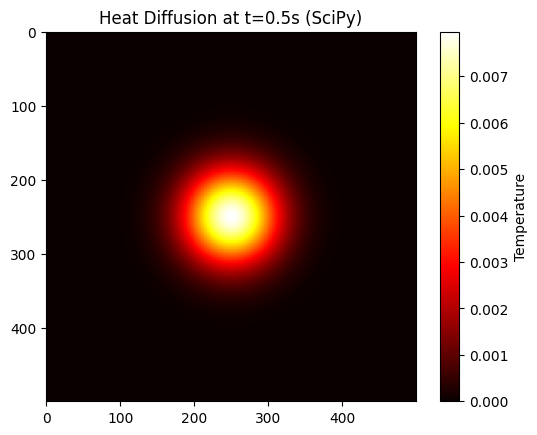

In [79]:
!nvcc -arch=sm_75 -gencode arch=compute_75,code=sm_75 heat_diffusion_2d.cu -o heat_diffusion_2d
!time ./heat_diffusion_2d
output_2d_heatdiff_cuda = np.loadtxt("cuda_output.txt", delimiter=",")
# Plot result
plt.imshow(output_2d_heatdiff_cuda, cmap='hot', interpolation='nearest')
plt.colorbar(label="Temperature")
plt.title("Heat Diffusion at t=0.5s (SciPy)")
plt.show()

In [82]:
#compare both data points from PDE and kuda kernel
np.all(np.isclose(output_2d_heatdiff, output_2d_heatdiff_cuda, atol=1e-1))

True